## prove xgboost can overfit this problem

## prove simple nn can overfit this problem

### The conclusion of this experiment is that the embeddings from the pretrained model significantly distinguish differences


In [1]:
import os
import torch

In [2]:
image_folder_path = "/Users/user/Documents/Coding/geo/notebook/data/full_image"
image_name_list = os.listdir(image_folder_path)
image_name_list.sort()
image_name_list = [
    image_name for image_name in image_name_list if not image_name.startswith(".")
]
image_path_list = [
    os.path.join(image_folder_path, image_name) for image_name in image_name_list
]

In [3]:
image_path_list

['/Users/user/Documents/Coding/geo/notebook/data/full_image/16099.png',
 '/Users/user/Documents/Coding/geo/notebook/data/full_image/16422.png',
 '/Users/user/Documents/Coding/geo/notebook/data/full_image/16732.png',
 '/Users/user/Documents/Coding/geo/notebook/data/full_image/16982.png',
 '/Users/user/Documents/Coding/geo/notebook/data/full_image/17046.png',
 '/Users/user/Documents/Coding/geo/notebook/data/full_image/17058.png',
 '/Users/user/Documents/Coding/geo/notebook/data/full_image/17115.png',
 '/Users/user/Documents/Coding/geo/notebook/data/full_image/17120.png',
 '/Users/user/Documents/Coding/geo/notebook/data/full_image/17140.png',
 '/Users/user/Documents/Coding/geo/notebook/data/full_image/17170.png',
 '/Users/user/Documents/Coding/geo/notebook/data/full_image/17197.png',
 '/Users/user/Documents/Coding/geo/notebook/data/full_image/17203.png',
 '/Users/user/Documents/Coding/geo/notebook/data/full_image/17204.png',
 '/Users/user/Documents/Coding/geo/notebook/data/full_image/1722

In [4]:
# feed model net
from urllib.request import urlopen
from PIL import Image
import timm

new_df_path = "/Users/user/Documents/Coding/geo/notebook/7 lat long with embedding.csv"
if not os.path.exists(new_df_path):
    # img = Image.open(urlopen(
    #     'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
    # ))
    # img = image_1
    output_dict = {}
    model = timm.create_model(
        "maxvit_tiny_tf_512.in1k",
        pretrained=True,
        num_classes=0,  # remove classifier nn.Linear
    )
    model = model.eval()
    data_config = timm.data.resolve_model_data_config(model)
    transforms = timm.data.create_transform(**data_config, is_training=False)

    for image_name in image_name_list:
        store_id = image_name.split(".")[0]
        image_path = os.path.join(image_folder_path, image_name)
        img = Image.open(image_path).convert("RGB")
        print(img.size)
        print(type(img))

        # get model specific transforms (normalization, resize)

        output = model(
            transforms(img).unsqueeze(0)
        )  # output is (batch_size, num_features) shaped tensor

        # or equivalently (without needing to set num_classes=0)

        output = model.forward_features(transforms(img).unsqueeze(0))
        # output is unpooled, a (1, 512, 16, 16) shaped tensor

        output = model.forward_head(output, pre_logits=True)
        output_dict[store_id] = output.detach().numpy()[0]
        # output is a (1, num_features) shaped tensor

/Users/user/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import numpy as np

r = 2
circle_area = np.pi * r**2
square_area = (2 * r) ** 2
circle_area, square_area, circle_area / square_area

(12.566370614359172, 16, 0.7853981633974483)

In [6]:
# rename columns by add prefix "embedding_"

In [7]:
# merge 2 df by index
import pandas as pd

# convert output_dict to dataframe
if os.path.exists(new_df_path) is False:
    output_df = pd.DataFrame.from_dict(output_dict, orient="index")
    output_df.head()
    output_df.columns = ["embedding_" + str(col + 1) for col in output_df.columns]
    # convert output_df store_id to int
    output_df["store_id"] = output_df.index
    output_df.store_id = output_df.store_id.astype(int)
    data_path = "/Users/user/Documents/Coding/geo/notebook/7 lat long.csv"
    df = pd.read_csv(data_path)
    # merge df with output_df with columns store_id
    df = pd.merge(df, output_df, on="store_id", how="inner")

    # df = pd.concat([df, output_df], axis=1)
    df.to_csv(new_df_path, index=False)

In [8]:
data_path = "/Users/user/Documents/Coding/geo/notebook/7 lat long.csv"
import pandas as pd

if os.path.exists(new_df_path):
    df = pd.read_csv(new_df_path)
else:
    df = pd.read_csv(data_path)
    df.head()
    # add embedding to df with store_id
    # loop embedding_1-512 to add to df
    for i in range(512):
        df[f"embedding_{i+1}"] = df["store_id"].apply(lambda x: output_dict[x][0][i])

    df.head()
    df.to_csv(new_df_path, index=False)

In [9]:
df.head()

,store_id,latitude,longitude,prov_namt,mockup_sale,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,...,embedding_503,embedding_504,embedding_505,embedding_506,embedding_507,embedding_508,embedding_509,embedding_510,embedding_511,embedding_512
0,16099,8.164963,98.296457,ภูเก็ต,5514,-0.647775,-0.250429,-0.661320,0.347508,-0.986047,...,0.883724,0.852938,0.647610,0.444694,0.202822,0.093807,-0.260356,0.439349,0.271511,0.106830
1,16422,13.859660,100.538382,นนทบุรี,93834,-0.636405,-0.708834,-0.241512,-0.393015,-0.827613,...,0.694378,0.279611,-0.071350,0.499804,-0.276750,0.703623,-0.548630,-0.270225,0.427221,0.198852
2,16732,7.194010,100.566282,สงขลา,69245,-0.776682,-0.194732,0.169644,-0.456144,-0.955256,...,0.351970,0.633368,0.659370,0.100348,0.493871,-0.199854,0.287869,0.054394,-0.432780,0.297601
3,16982,13.788561,100.599841,กรุงเทพมหานคร,71188,-0.421329,-0.420626,0.398620,0.150204,-0.359852,...,0.452612,0.572809,0.555344,0.283643,-0.111879,-0.280260,-0.663806,-0.138071,0.156335,-0.118202
4,17046,6.582589,100.671930,สงขลา,41589,-0.934698,0.681198,0.633629,0.228640,-0.796288,...,0.807826,0.841895,-0.283328,0.051602,0.138628,-0.489047,-0.335959,0.849277,-0.694231,0.772979


In [10]:
# save df

In [11]:
# use embedding to predict mockup_sale with xgboost
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np

# linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# get all column has embedding_ prefix
embedding_columns = [col for col in df.columns if col.startswith("embedding_")]
# assign to x
x = df[embedding_columns]
y = df["mockup_sale"]
# make train test the same to test overfitting

x_test = x_train = x
y_test = y_train = y

In [12]:
x_train.shape, y_train.shape

((15, 512), (15,))

In [13]:
import matplotlib.pyplot as plt

Mean Squared Error: 6.329218546549479e-05


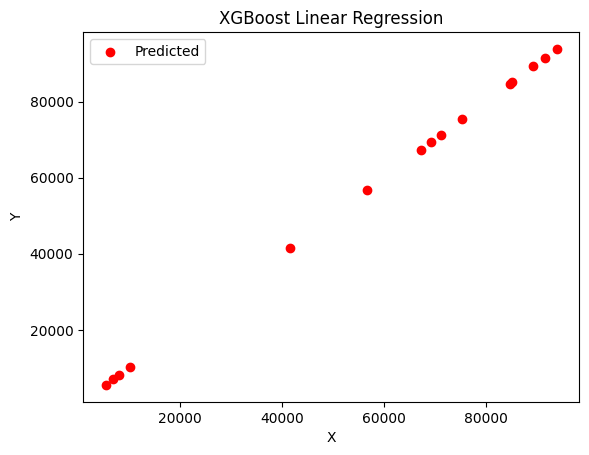

In [14]:
# Create an XGBoost regressor
regressor = xgb.XGBRegressor(objective="reg:squarederror", seed=42)

# Train the model
regressor.fit(x_train, y_train)

# Make predictions on the test set
y_pred = regressor.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot the results
# plt.scatter(x_test, y_test, color="black", label="Actual")
plt.scatter(y_test, y_pred, color="red", label="Predicted")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("XGBoost Linear Regression")
plt.legend()
plt.show()

In [22]:
from typing import Any
from lightning.pytorch.utilities.types import STEP_OUTPUT
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import lightning as pl

from lightning.pytorch.loggers import TensorBoardLogger


# Define a simple dataset
class PriceDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


# Define a simple feedforward neural network
class PricePredictor(pl.LightningModule):
    def __init__(self, input_size):
        super(PricePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.training_step_loss = []

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = nn.MSELoss()(y_pred.flatten(), y)
        self.training_step_loss.append(loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.01)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = nn.MSELoss()(y_pred.flatten(), y)
        self.log("test_loss", loss)

    def on_train_epoch_end(self):
        # print("\n\tself.training_step_loss", self.training_step_loss)
        # print("\n\tself.training_step_loss", self.training_step_loss[0].shape)
        # print("\n\tself.training_step_loss", self.training_step_loss[0])
        # print()
        # avg_loss = torch.stack([x["loss"] for x in self.training_step_loss]).mean()
        avg_loss = torch.stack(
            [x.detach().cpu() for x in self.training_step_loss]
        ).mean()
        self.log("train_loss", avg_loss.item(), on_epoch=True)


# Generate some random data for demonstration purposes
np.random.seed(42)
# features = np.random.rand(100, 512, 1)  # 100 samples with 512x1 features each
# labels = (
#     3 * features[:, 0, 0]
#     + 2 * features[:, 1, 0]
#     + 1.5 * features[:, 2, 0]
#     + 1
#     + 0.1 * np.random.randn(100)
# )

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     x, y, test_size=0.2, random_state=42
# )
X_train = X_test = np.array(x)
y_train = y_test = np.array(y)
# Standardize the features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(-1, 512, 1)
# X_test = scaler.transform(X_test.reshape(-1, 1)).reshape(-1, 512, 1)
# y_train = np.array(y_train)
# Create data loaders
train_dataset = PriceDataset(X_train, y_train)
test_dataset = PriceDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize the model
input_size = X_train.shape[1:]
model = PricePredictor(input_size[0])

# Initialize a PyTorch Lightning Trainer
logger = TensorBoardLogger("tb_logs", name="my_model")

trainer = pl.Trainer(max_epochs=250, logger=logger)

# Train the model
trainer.fit(model, train_loader)

# Test the model
trainer.test(dataloaders=test_loader)

# Make predictions
model.eval()
with torch.no_grad():
    example_input = torch.tensor(X_test[:5], dtype=torch.float32)
    predictions = model(example_input).flatten().numpy()

print("Example Predictions:", predictions)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 131 K 
1 | fc2  | Linear | 32.9 K
2 | fc3  | Linear | 8.3 K 
3 | fc4  | Linear | 65    
--------------------------------
172 K     Trainable params
0         Non-trainable params
172 K     Total params
0.690     Total estimated model params size (MB)


Epoch 249: 100%|██████████| 2/2 [00:00<00:00, 119.27it/s, v_num=22]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 2/2 [00:00<00:00, 17.18it/s, v_num=22] 

Restoring states from the checkpoint path at tb_logs/my_model/version_22/checkpoints/epoch=249-step=500.ckpt
Loaded model weights from the checkpoint at tb_logs/my_model/version_22/checkpoints/epoch=249-step=500.ckpt



Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 210.39it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │  1.8628437828738242e-05   │
└───────────────────────────┴───────────────────────────┘

Example Predictions: [ 5513.9995 93834.01   69245.01   71188.01   41589.004 ]


In [23]:
with torch.no_grad():
    example_input = torch.tensor(X_test[:5], dtype=torch.float32)
    predictions = model(example_input).flatten().numpy()
    predictions = [int(round(pred)) for pred in predictions]

print("Example Predictions:", predictions)
print("Ground Truth:", y_test[:5])

Example Predictions: [5514, 93834, 69245, 71188, 41589]
Ground Truth: [ 5514 93834 69245 71188 41589]


In [24]:
y_test[:5]

array([ 5514, 93834, 69245, 71188, 41589])

In [ ]:
import numpy as np


def mean_squared_error(y_true, y_pred):
    """
    Calculate Mean Squared Error (MSE).

    Parameters:
    - y_true: numpy array or list, true values
    - y_pred: numpy array or list, predicted values

    Returns:
    - mse: float, Mean Squared Error
    """
    N = len(y_true)
    mse = np.sum((y_true - y_pred) ** 2) / N
    return mse


# Example usage:
# Assuming y_true and y_pred are your true and predicted values
y_true = np.array([1, 2, 3, 4, 5])
y_pred = np.array([1.5, 2.5, 3.5, 4.5, 5.5])

mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error: {mse}")

4302521856.0